# Code to identify mis-classified points and explore their features

July 21, 2020


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import subprocess as sp
import pickle
import ipywidgets as widgets
import time

import glob

In [2]:
from sklearn.metrics import roc_curve

In [3]:
%matplotlib widget

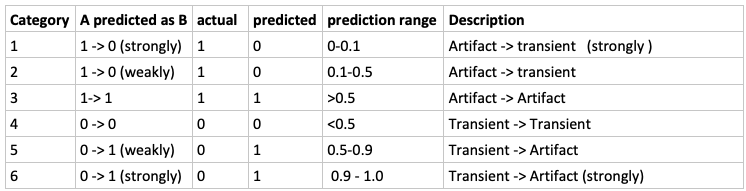
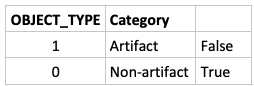

## Read test data and IDs

In [4]:
ls /global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/results_data/results

final_train_and_test_new_labels_bigger_trainset/
test_on_full_dataset_to_identify_mislabelled_points/
test_with_new_labels/
test_with_new_labels_renamed_models/
test_with_old_labels/
train_and_test_with_new_labels/


In [5]:
def f_get_preds_df(results_dir,model_lst=[1,2,3,4]):

    ## Key index  classification_index 
    classification_key={1:'sig_bkg_strong',2:'sig_bkg_weak', 3:'sig_sig',4:'bkg_bkg',5:'bkg_sig_weak',6:'bkg_sig_strong'}
    def f_classify_pred(series,col):
        '''
        Read in a pandas series and give category of output 1-6 for each prediction
        '''
        if   ((series.test==1.0) & (series[col]<=0.1)) : val=1
        elif ((series.test==1.0) & ((series[col]>0.1) & (series[col]<0.5))): val=2
        elif ((series.test==1.0) & (series[col]>=0.5)): val=3
        elif ((series.test==0.0) & (series[col]<=0.5)): val=4
        elif ((series.test==0.0) & ((series[col]<0.9) & (series[col]>0.5))): val=5
        elif ((series.test==0.0) & (series[col]>=0.9)) : val=6

        else: raise SystemError

        return val

    
    df_preds=pd.DataFrame()
    # Pick any test data, all are same
    test_fname=results_dir+'ytest_3.test'
    ID_fname=results_dir+'id_test_3.test'

    df_preds['test']=np.loadtxt(test_fname,dtype=np.int16)
    df_preds['ID']=np.loadtxt(ID_fname,dtype=np.int32)

    print(df_preds.shape)

    for count,model_num in enumerate(model_lst):
        model_label=count+1
        col='m_'+str(model_label)
        fname=results_dir+'ypred_{0}.test'.format(model_num)
        df_preds[col]=np.loadtxt(fname)

        pred_class=df_preds.apply(lambda row: f_classify_pred(row,col),axis=1).values
        df_preds['pred_'+col]=pred_class ## Add pred_class as a new column

    ### Read random forest results from your trained model
    fname=glob.glob(results_dir+'rf_*.csv')[0]
    df_rf=pd.read_csv(fname,sep=',')
    print(df_rf.shape,df_rf.columns)
    # Merge dataframes on ID column 
    df_preds=df_preds.merge(df_rf,on='ID')

    ### Compute prediction classes for Random forest results
    col='m_rf'
    pred_class=df_preds.apply(lambda row: f_classify_pred(row,col),axis=1).values
    new_col='pred_'+col
    df_preds[new_col]=pred_class
    print(df_preds.shape)
    
    return df_preds

In [6]:
main_dir='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/'

df1=f_get_preds_df(main_dir+'test_with_old_labels/',[3,8,9,16])
df2=f_get_preds_df(main_dir+'test_with_new_labels_renamed_models/',[1,2,3,4])

(44948, 2)
(42144, 2) Index(['ID', 'm_rf'], dtype='object')
(42144, 12)
(44948, 2)
(42144, 2) Index(['ID', 'm_rf'], dtype='object')
(42144, 12)


In [7]:
df3=f_get_preds_df(main_dir+'final_train_and_test_new_labels_bigger_trainset/',[1,2,3,4])

(179792, 2)
(168637, 2) Index(['ID', 'm_rf'], dtype='object')
(168637, 12)


In [8]:
df1.head()

,test,ID,m_1,pred_m_1,m_2,pred_m_2,m_3,pred_m_3,m_4,pred_m_4,m_rf,pred_m_rf
0,1,9706039,0.999041,3,0.999010,3,0.998882,3,0.986039,3,0.970000,3
1,0,11177538,0.000265,4,0.000449,4,0.000044,4,0.000002,4,0.000000,4
2,1,8624980,0.995062,3,0.999886,3,0.999813,3,0.999533,3,0.993333,3
3,1,11192359,0.989494,3,0.977079,3,0.990088,3,0.977761,3,0.930000,3
4,1,10891233,0.999783,3,0.999787,3,0.999989,3,0.999903,3,1.000000,3


In [9]:

def f_get_category_summary(df):
    '''  Get percentage of points in each category for each model for a given run dataframe'''
    col_list=df.columns[df.columns.str.startswith('pred_m_')]
    df_summary=pd.DataFrame(columns=col_list)

    for category in range(1,7):
        for col in col_list:
            frac=df[df[col]==category].shape[0]/df.shape[0] *100
            df_summary.loc[category-1,col]=frac
    #         print(category,col,frac)

    display(df_summary)


In [10]:
f_get_category_summary(df1)
f_get_category_summary(df2)
f_get_category_summary(df3)

,pred_m_1,pred_m_2,pred_m_3,pred_m_4,pred_m_rf
0,0.35355,0.491173,0.76642,0.607441,0.154233
1,0.754556,0.856587,0.761674,1.20776,0.970482
2,48.4363,48.1967,48.0163,47.7292,48.4197
3,48.3841,48.6499,48.778,48.9963,48.4268
4,1.23149,0.854214,0.61456,0.806758,1.61114
5,0.839977,0.9515,1.06302,0.652525,0.417616


,pred_m_1,pred_m_2,pred_m_3,pred_m_4,pred_m_rf
0,0.196944,0.325076,0.310839,0.434226,0.0925399
1,0.835232,0.820995,0.474563,1.33827,0.979973
2,48.9512,48.8373,49.198,48.2109,48.9109
3,48.7638,48.8919,48.4743,49.1909,48.479
4,1.02031,0.794894,0.771166,0.659643,1.39284
5,0.232536,0.329822,0.771166,0.166097,0.144742


,pred_m_1,pred_m_2,pred_m_3,pred_m_4,pred_m_rf
0,0.35698,0.457195,0.628569,0.533098,0.112668
1,0.830186,0.58113,0.498704,1.02469,1.00927
2,49.1375,49.2863,49.1974,48.7669,49.2027
3,48.5753,48.516,48.5908,48.7983,48.0755
4,0.766736,0.635092,0.465497,0.607814,1.38048
5,0.33326,0.524203,0.619081,0.269217,0.219406


## Plots


In [11]:
# df1.hist(column='pred_m_1',bins=20)
# df1.hist(column='pred_m_rf',bins=20)

In [12]:
def f_hist_compare(df,col1,value):
    
    col_list=[ i for i in df.columns.values if i[:4]=='pred']
    cols=[col for col in col_list if col != col1] # Pick columns except the one used to splice df
    
    df[df[col1]==value].plot(kind='hist',y=cols,subplots=True,grid=True,bins=12)
    print('Total points in category',df[df[col1]==value].shape[0])
    

def f_hist_predictions(df,column='m_3'):
    sig_preds=df[df.test==1][column].values
    bkg_preds=df[df.test==0][column].values
#     plt.figure()
    # plt.hist(sig_preds,bins=10,alpha=0.5,color='y')
    # plt.hist(bkg_preds,bins=10,alpha=0.5,color='b')
    plt.hist([sig_preds,bkg_preds],bins=20,alpha=0.5,label=[column+' :Artifact = 1',column+' :Non-artifact = 0'])
    plt.legend()
    

def f_roc(df,col,label,fig_type='mdr'):

    fpr,tpr,threshold=roc_curve(df.test,df[col],pos_label=None)
    #     plt.figure()
    
    if fig_type=='mdr':
#         x,y=1-tpr,fpr 
        x,y=fpr,(1-tpr)     # The roc curve flip: mdr-> fpr; fpr-> (1-tpr)
        plt.plot(x, y,linestyle='',label=label,markersize=2,marker='*')
        # ### Reference points in mdr plot in paper
        plt.plot(0.03,0.038,marker='s',markersize=8,color='k')
        plt.plot(0.04,0.024,marker='s',markersize=8,color='k')
        plt.plot(0.05,0.016,marker='s',markersize=8,color='k')

        plt.xlabel('MDR')
        plt.ylabel('FPR')
        plt.xlim(0,0.1)
        plt.ylim(0,0.05)
    
    if fig_type=='tpr':
        x,y=(1-tpr),(1-fpr)     # The roc curve flip: fpr-> (1-tpr); tpr-> (1-fpr)
        plt.plot(x, y,linestyle='',label=label,markersize=2,marker='*')
        plt.xlabel('FPR')
        plt.ylabel('TPR')


####The ROC curve flip argument

Since True=1 in keras, but Non-Artifact is defined as 0 in the paper, 
Tp <-> Tn and Fn <-> Fp

Actual roc curve is x=mdr, y=fpr


mdr=Fn/(Tp+Fn) -> Fp/(Tn+Fp) = fpr
fpr=Fp/(Tn+Fp) -> Fn/(Tp+Fn) = mdr = fnr = 1-tpr


Hence we get an mdr <-> fpr flip


### Roc curves with old labels

In [13]:
### Roc curve comparison
plt.figure()
f_roc(df1,'m_1','model 1',fig_type='mdr')
f_roc(df1,'m_2','model 2',fig_type='mdr')
f_roc(df1,'m_3','model 3',fig_type='mdr')
f_roc(df1,'m_4','model 4',fig_type='mdr')
f_roc(df1,'m_rf','Random forest',fig_type='mdr')
# f_roc(df3,'m_1','Random forest2',fig_type='mdr')

# plt.xscale('log')
plt.legend()
plt.title("MDR roc curve for old labels")


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'MDR roc curve for old labels')

In [14]:
## Histograms with old labels
plt.figure()
f_hist_predictions(df1,column='m_rf')
plt.figure()
f_hist_predictions(df1,column='m_1')
plt.text(0.4, 10000,' Model 1')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.4, 10000, ' Model 1')

In [15]:
## Histogram of signal points strongly mis-classified as background
f_hist_compare(df1,'pred_m_1',1)
f_hist_compare(df1,'pred_m_1',6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Total points in category 149


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Total points in category 354


## Results with relabeled test set

In [16]:
df=df2

In [17]:
### Roc curve comparison
plt.figure()
f_roc(df,'m_1','model 1',fig_type='mdr')
f_roc(df,'m_2','model 2',fig_type='mdr')
f_roc(df,'m_3','model 3',fig_type='mdr')
f_roc(df,'m_4','model 4',fig_type='mdr')
f_roc(df,'m_rf','Random forest',fig_type='mdr')
# plt.xscale('log')
plt.legend()
plt.title("MDR roc curve for relabeled test dataset")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'MDR roc curve for relabeled test dataset')

## Final results with relabeled dataset

In [18]:
df=df3

In [19]:
### Roc curve comparison
plt.figure()
f_roc(df,'m_1','model 1',fig_type='tpr')
# f_roc(df,'m_2','model 2',fig_type='tpr')
# f_roc(df,'m_3','model 3',fig_type='tpr')
# f_roc(df,'m_4','model 4',fig_type='tpr')
f_roc(df,'m_rf','Random forest',fig_type='tpr')

plt.xscale('log')
plt.xlim(0,0.04)

plt.legend()
# plt.title("TPR roc curve")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-19-dfbe09fc61f6>:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.04)


In [20]:
### Roc curve comparison
plt.figure()
f_roc(df,'m_1','model 1',fig_type='mdr')
# f_roc(df,'m_2','model 2',fig_type='mdr')
# f_roc(df,'m_3','model 3',fig_type='mdr')
# f_roc(df,'m_4','model 4',fig_type='mdr')
f_roc(df,'m_rf','Random forest',fig_type='mdr')
# plt.xscale('log')
plt.legend()
plt.title("MDR roc curve for relabeled dataset")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'MDR roc curve for relabeled dataset')

In [57]:
### Category stats of final results
